<a href="https://colab.research.google.com/github/catalyst2064/Fiber/blob/main/Fiber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実装編（その０） 関数

### ライブラリのインポートなど

In [ ]:
#--------------------------------------------------
# 必須ライブラリ
#--------------------------------------------------

import numpy as np

#--------------------------------------------------
# データを可視化
#--------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd

#--------------------------------------------------
# データセットの取得とデータの前処理
#--------------------------------------------------

import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.datasets import load_digits
import sklearn.preprocessing as prep

#--------------------------------------------------
# FiberとKerasの動作を比較
#--------------------------------------------------

from tensorflow import keras

#--------------------------------------------------
# ユーティリティ
#--------------------------------------------------

class Object: pass                                # 最小限のオブジェクトを生成

def judge(flag):                                  # 論理値を判定文字列に変換
    return '✓ PASS' if flag else '✗ FAIL'

#--------------------------------------------------
# 動作環境の設定
#--------------------------------------------------

%config InlineBackend.figure_format = 'retina'    # 図の描画を高精細に
np.set_printoptions(formatter={'float':'{: .8f}'.format}) # 数値の表示を整える


# 実装編（その１） 関数

In [ ]:
#--------------------------------------------------
# _fneu_ ← 線形変換関数（linear transformation function）
#--------------------------------------------------

def affine(w, x, b):                              # バイアスを含む（デフォルト）
    return w @ x + b

def linear(w, x, b):                              # バイアスを含まない
    return w @ x

#--------------------------------------------------
# _fini_ ← 初期化関数（initialization function）
#--------------------------------------------------

def glorot_uniform(nodes, links):                 # glorot uniform（デフォルト）
    min = -np.sqrt(6 / (nodes + links))
    max =  np.sqrt(6 / (nodes + links))
    return np.random.uniform(min, max, (nodes, links))

def he_normal(nodes, links):                      # he normal (for ReLU)
    std = np.sqrt(2 / links)
    return np.random.normal(0.0, std, (nodes, links))

def xavier_normal(nodes, links):                  # xavier normal (for sigmoid, tanh)
    std = 1 / np.sqrt(links)
    return np.random.normal(0.0, std, (nodes, links))

#--------------------------------------------------
# _fact_ ← 活性化関数（activation function）
#--------------------------------------------------

def sigmoid(x):                                   # sigmoid関数
    return 1 / (1 + np.exp(-x))

def tanh(x):                                      # tanh関数
    return np.tanh(x)

def relu(x):                                      # ReLU関数
    return np.maximum(0, x)

def softmax(x):                                   # softmax関数
    exps = np.exp(x - np.max(x))                  # オーバーフローを防ぐために各要素から最大値をマイナス
    return exps / np.sum(exps)

def identity(x):                                  # 恒等関数
    return x

#--------------------------------------------------
# _fder_ ← 導関数（derivative function）
#--------------------------------------------------

def sigmoid_der(x):                               # sigmoid関数の導関数
    return sigmoid(x) * (1.0 - sigmoid(x))

def tanh_der(x):                                  # tanh関数の導関数
    return 1.0 - (tanh(x) ** 2)

def relu_der(x):                                  # ReLU関数の導関数
    return np.where(x > 0, 1, 0)

def actloss_der(y, t):                            # 活性化関数＋損失関数の導関数
    return y - t

#--------------------------------------------------
# _flos_ ← 損失関数（loss function）
#--------------------------------------------------

def sse(y, t):                                    # 二乗和誤差関数
    return 0.5 * np.sum((y - t) ** 2)

def bin_xentropy(y, t):                           # 二値交差エントロピー関数
    return float(-t * np.log(y) - (1 - t) * np.log(1 - y))

def cat_xentropy(y, t):                           # 交差エントロピー関数
    delta = 1e-7                                  # ゼロ除算を防ぐための微小な値
    return -np.sum(t * np.log(y + delta))

#--------------------------------------------------
# _feva_ ← 評価関数（evaluation function）
#--------------------------------------------------

def bin_accuracy(y, t):                           # 正解率（二値）
    def isequal(y, t):
        return 1 if np.round(y) == np.round(t) else 0
    return np.mean([isequal(y, t) for (y, t) in zip(y, t)])

def cat_accuracy(y, t):                           # 正解率（多値）
    def isequal(y, t):
        return 1 if np.argmax(y) == np.argmax(t) else 0
    return np.mean([isequal(y, t) for (y, t) in zip(y, t)])


## 初期化関数のグラフ

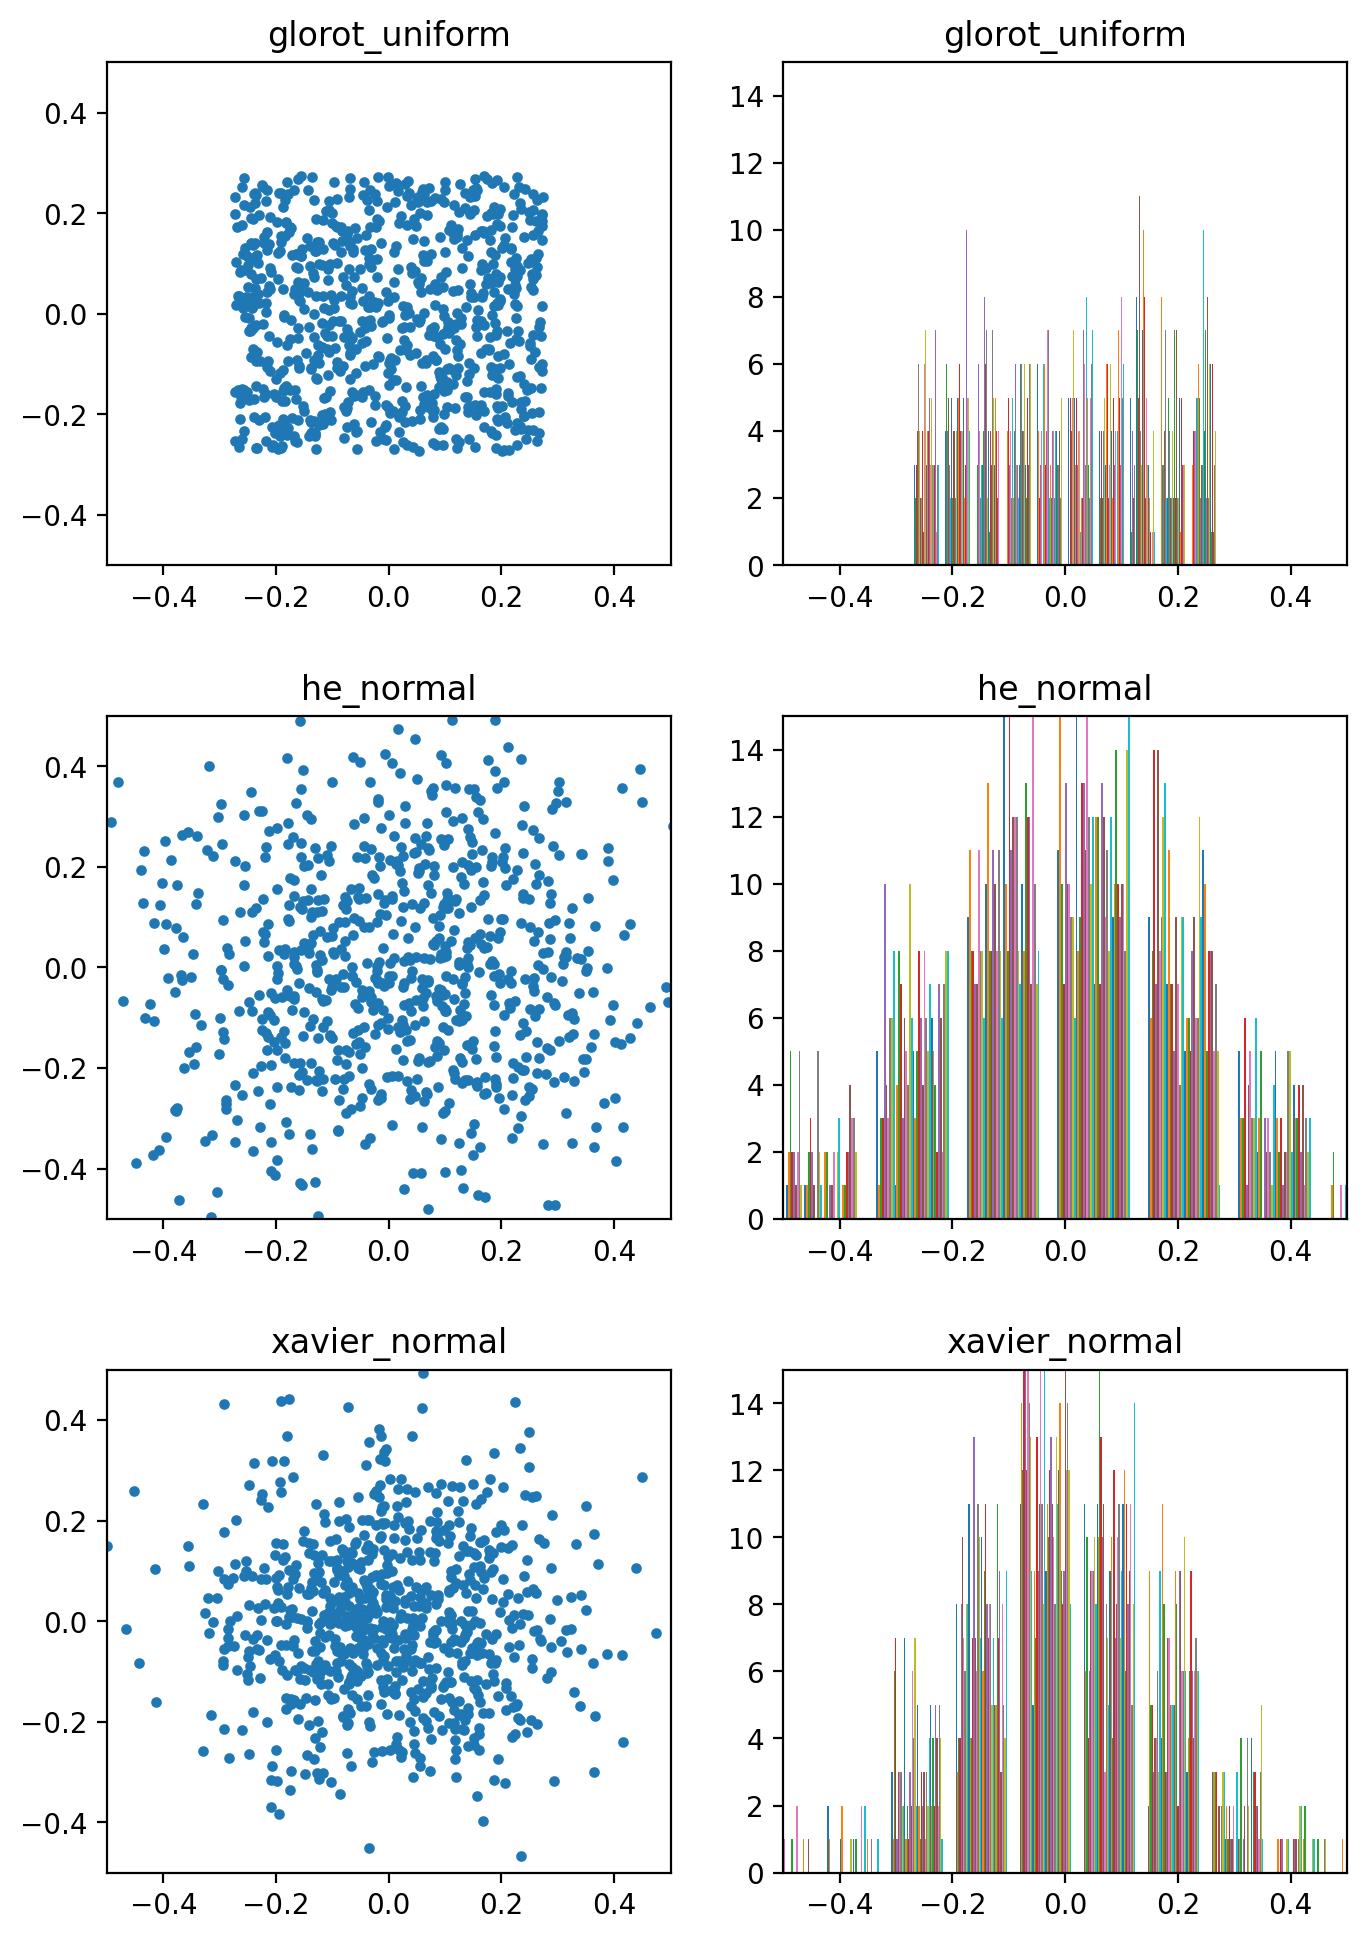

In [ ]:
nodes = 40
links = 40

funcs = [
    ('glorot_uniform', glorot_uniform(nodes, links)),
    ('he_normal',      he_normal(nodes, links)     ),
    ('xavier_normal',  xavier_normal(nodes, links) )
]

plt.figure(figsize=(8, 16))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
for (i, func) in enumerate(funcs):
    plt.subplot(4, 2, i*2 + 1)                    # 散布図
    plt.title(func[0])
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.scatter(func[1][:20], func[1][20:], 8)
    plt.subplot(4, 2, i*2 + 2)                    # ヒストグラム
    plt.title(func[0])
    plt.xlim(-0.5, 0.5)
    plt.ylim(0, 15)
    plt.hist(func[1])
plt.show()


## 活性化関数のグラフ

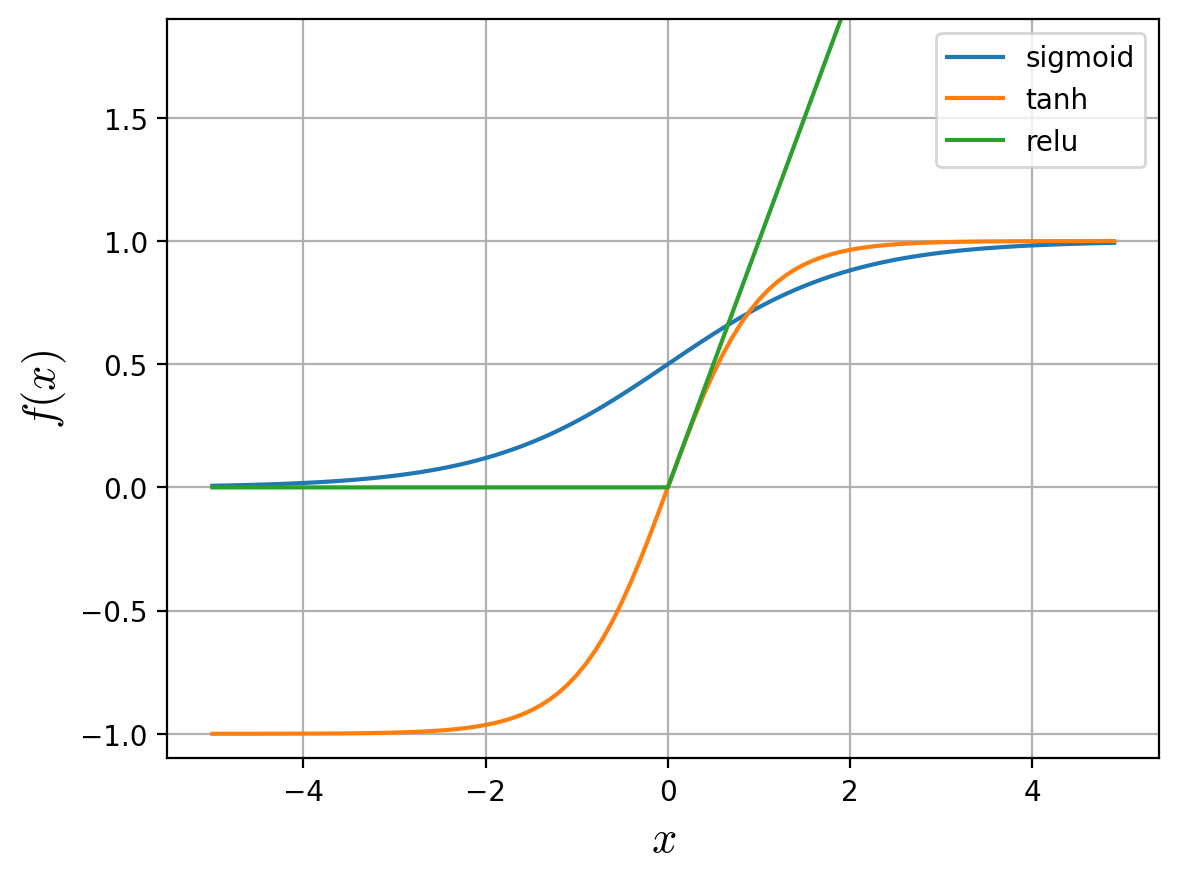

In [ ]:
x = np.arange(-5.0, 5.0, 0.1)

funcs = [
    ('sigmoid', sigmoid(x)),
    ('tanh',    tanh(x)),
    ('relu',    relu(x))
]

plt.ylim(-1.1, 1.9)
plt.ylabel(r'$f(x)$', size=16, math_fontfamily='cm')
plt.xlabel(r'$x$', size=16, math_fontfamily='cm')
plt.grid()
for func in funcs:
    plt.plot(x, func[1], label=func[0])
plt.legend()
plt.show()


## 導関数のグラフ

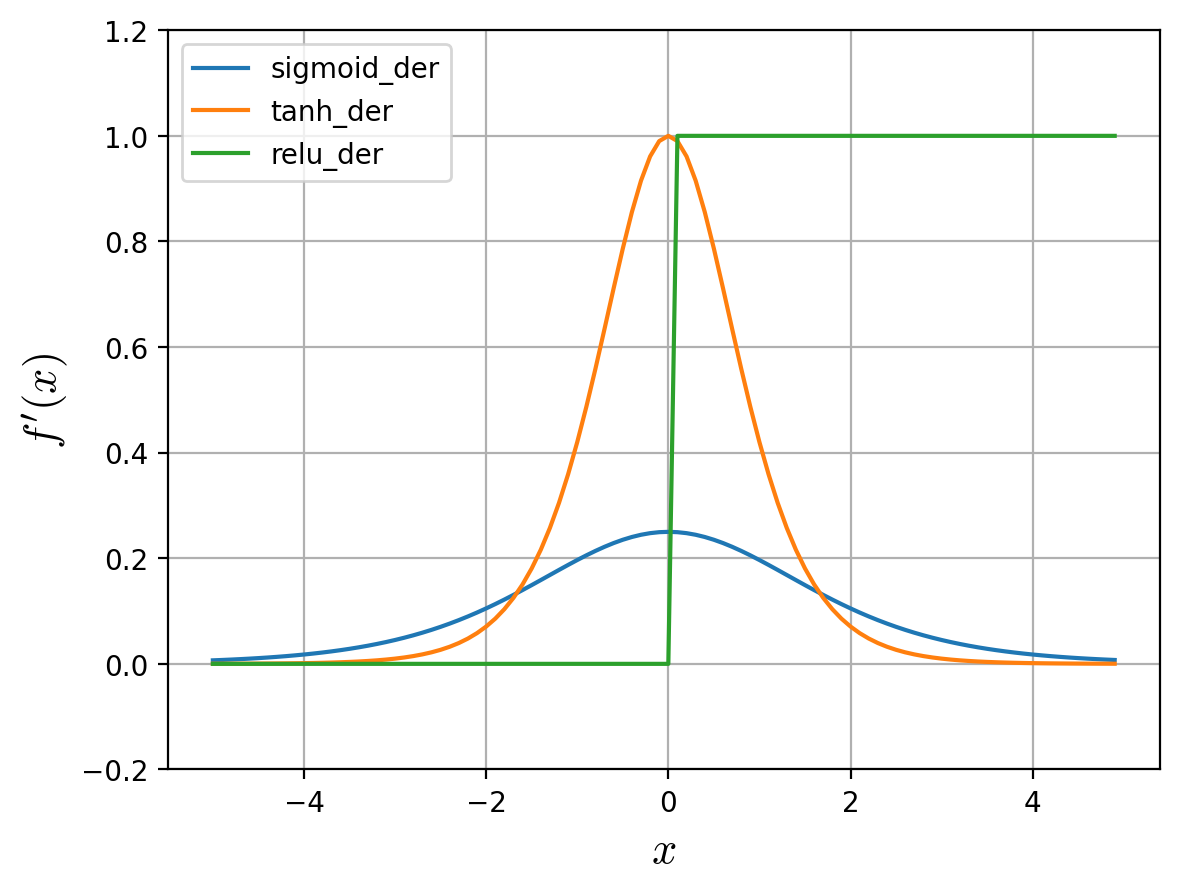

In [ ]:
x = np.arange(-5.0, 5.0, 0.1)

funcs = [
    ('sigmoid_der', sigmoid_der(x)),
    ('tanh_der',    tanh_der(x)),
    ('relu_der',    relu_der(x))
]

plt.ylim(-0.2, 1.2)
plt.ylabel(r"$f'(x)$", size=16, math_fontfamily='cm')
plt.xlabel(r'$x$', size=16, math_fontfamily='cm')
plt.grid()
for func in funcs:
    plt.plot(x, func[1], label=func[0])
plt.legend()
plt.show()


# 実装編（その２） 本体

In [ ]:
#--------------------------------------------------
# ニューロン（パラメータを管理）
#--------------------------------------------------
class Neuron:
    def __init__(self, env, core):
        self.w = core                             # 重みの一覧
        self.b = np.random.normal(0.0, 0.1)       # バイアス（１個）
        self._fneu_ = env.fneu                    # ニューロンが使用する関数（１個）を確定
        self.eta = env.eta                        # 学習率
        self.grad_w = []                          # 重みの勾配を蓄積（ミニバッチ対応）
        self.grad_b = []                          # バイアスの勾配を蓄積（ミニバッチ対応）

    def output(self, x):                          # ニューロンの出力を計算
        return self._fneu_(self.w, x, self.b)     #⬅ _fneu_（線形変換関数）

    def calcgrad(self, x, delta):                 # 勾配を計算
        self.grad_w.append(x * delta)             # 重みの勾配
        self.grad_b.append(delta)                 # バイアスの勾配
        return self.w * delta                     # 逆伝播させる入力の勾配（レイヤで結線どおりに合算する）

    def update(self):                             # パラメータを更新
        self.w -= np.sum(self.grad_w, axis=0) * self.eta  # 重みを更新
        self.b -= np.sum(self.grad_b, axis=0) * self.eta  # バイアスを更新
        self.grad_w = []
        self.grad_b = []

#--------------------------------------------------
# レイヤ（ニューロンを管理）
#--------------------------------------------------
class Layer:
    def __init__(self, fun, env, nodes, links):
        self.neurons = []                         # ニューロンの一覧（nodes個）
        (self._fact_, self._fder_, self._fini_) = fun # レイヤが使用する関数（３個）を確定
        self.x = []                               # レイヤへの入力  （逆伝播において勾配の計算で使用）
        self.u = []                               # ニューロンからの出力（逆伝播において誤差の計算に使用）
        for core in self._fini_(nodes, links):    #⬅ _fini_（初期化関数）／coreにはlinks個の乱数が入る
            self.neurons.append(Neuron(env, core)) # ニューロンを生成して一覧に追加する

    def output(self, x):                          # レイヤからの出力を計算
        self.x = x                                # レイヤへの入力を保存
        self.u = np.array([neuron.output(self.x) for neuron in self.neurons]) # ニューロンに出力の計算を依頼する
        return self._fact_(self.u)                #⬅ _fact_（活性化関数）／この計算結果が次のレイヤに渡される

    def calcgrad(self, delta):                    # 入力の勾配を計算
        grad_x = []                               # 入力の勾配を蓄積
        for (neuron, delta) in zip(self.neurons, delta):
            grad_x.append(neuron.calcgrad(self.x, delta)) # ニューロンに勾配の計算を依頼する
        return np.sum(grad_x, axis=0)             # 蓄積した入力の勾配をリンクの結線どおりに合算

    def update(self):                             # パラメータを更新
        for neuron in self.neurons:
            neuron.update()                       # ニューロンにパラメータの更新を依頼する

#--------------------------------------------------
# コーテクス（レイヤを管理）
#--------------------------------------------------
class Cortex:
    def __init__(self, links, eta, fneu):
        self.layers = []                          # レイヤの一覧
        self.links = links                        # 最初のレイヤの１ニューロンに接続されるリンクの数
        self.env = Object()                       # ニューロンの動作を規定する環境変数
        self.env.eta = eta                        # 学習率
        self.env.fneu = fneu                      # 線形変換関数

    def add(self, nodes, fun):                    # レイヤを追加
        self.layers.append(Layer(fun, self.env, nodes, self.links)) # レイヤを生成して一覧に追加する
        self.links = nodes                        # 次のレイヤの１ニューロンに接続されるリンクの数

    def forward(self, x):                         # 順伝播
        for layer in self.layers:                 # 深層対応ループ（出力層に向かって行く）
            x = layer.output(x)
        return x                                  # 最終レイヤ（出力層）からの出力値を返す

    def backward(self, delta):                    # 逆伝播
        layers = list(reversed(self.layers))      # レイヤを逆順に並べる
        grad_x = layers[0].calcgrad(delta)        # 最終レイヤ（出力層）の勾配を計算
        for layer in layers[1:]:                  # 深層対応ループ（入力層に向かって行く）
            delta = grad_x * layer._fder_(layer.u) #⬅ _fder_（導関数）／入力の勾配から誤差を計算
            grad_x = layer.calcgrad(delta)        # 中間層の勾配を計算

    def onecycle(self, x, t):                     # 順伝播と逆伝播を１サイクルだけ実行
        y = self.forward(x)                       # 順伝播
        delta = actloss_der(y, t)                 #⬅ actloss_der（導関数）／誤差を計算
        self.backward(delta)                      # 逆伝播
        return y                                  # 予測値を返す

    def update(self):                             # パラメータを更新
        for layer in self.layers:
            layer.update()                        # レイヤにパラメータの更新を依頼する

#--------------------------------------------------
# モデル
#--------------------------------------------------
class Model:
    def __init__(self, nw, eta, fneu=affine):
        self.cortex = Cortex(nw, eta, fneu)       # モデルが使用するコーテクスを１個確保
        self._flos_ = None
        self._feva_ = None

    @staticmethod
    def idx_mini(num, batch_size):                # ミニバッチ用のシャッフルされたインデックスを作成
        shuffle = np.random.permutation(num)      # シャッフル
        return [shuffle[i:i+batch_size] for i in range(0, num, batch_size)] # ミニバッチ形式に変換

    @staticmethod
    def show_progress(epo, epochs, hist):         # 最適化の進行状況を表示
        print(f'epoch = {epo+1:>4d} / {epochs:>4d}, ', end='')
        print(f'loss = {hist.loss[-1]:.8f}, ', end='')
        print(f'accu = {hist.accu[-1]:.8f}')

    def add(self, nodes, fact, fder=lambda x:None, fini=glorot_uniform): # レイヤを追加
        fun = (fact, fder, fini)                  # レイヤが使用する関数群
        self.cortex.add(nodes, fun)               # コーテクスにレイヤの追加を依頼

    def measurer(self, flos, feva):               # 測定系の関数を設定
        self._flos_ = flos                        # 損失関数（モデルが使用する関数（1/2個）を確定）
        self._feva_ = feva                        # 評価関数（モデルが使用する関数（2/2個）を確定）

    def fit(self, x, t, epochs, batch_size, verbose=0): # 最適化
        hist = Object()
        hist.loss = []                            # 損失の履歴（最終的な結果）
        hist.accu = []                            # 精度の履歴（最終的な結果）
        for epo in range(epochs):                 # エポック開始
            loss, pred, targ = [], [], []         # 損失・予測値・正解値の履歴（１エポックの計算で使用）
            whole = self.idx_mini(len(x), batch_size) # ミニバッチ用のシャッフルされたインデックスを作成
            for mini in whole:                    # すべてのミニバッチが終了するまで繰り返す
                for i in mini:                    # ミニバッチ開始
                    y = self.cortex.onecycle(x[i], t[i]) # 順伝播と逆伝播を１サイクルだけ実行
                    loss.append(self._flos_(y, t[i])) #⬅ _flos_（損失関数）／損失の履歴を更新
                    pred.append(y)                # 予測値の履歴を更新
                    targ.append(t[i])             # 正解値の履歴を更新
                self.cortex.update()              # ミニバッチ終了、パラメータを更新
            hist.loss.append(np.mean(loss))       # 損失の履歴を更新
            hist.accu.append(self._feva_(pred, targ)) #⬅ _feva_（評価関数）／精度の履歴を更新
            if verbose: self.show_progress(epo, epochs, hist) # 最適化の進行状況を表示
        return hist

    def evaluate(self, vx, vt):                   # 評価
        loss, pred = [], []                       # 損失・予測値の履歴
        for (x, t) in zip(vx, vt):
            y = self.cortex.forward(x)            # 順伝播
            loss.append(self._flos_(y, t))        #⬅ _flos_（損失関数）／損失の履歴を更新
            pred.append(y)
        eval = Object()
        eval.loss = np.mean(loss)                 # 損失を計算（平均）
        eval.accu = self._feva_(pred, vt)         #⬅ _feva_（評価関数）／精度を計算
        return eval

    def predict(self, whole):                     # 予測
        pred = []                                 # 予測値の履歴
        for x in whole:
            pred.append(self.cortex.forward(x))   # 順伝播／予測値の履歴を更新
        return pred


# 動作確認編

## 動作確認をサポートするユーティリティ

In [ ]:
#--------------------------------------------------
# Fiberの重みをダイレクトに操作
#--------------------------------------------------
class CoreFiber:
    @staticmethod
    def coreinit(model, w):                       # 重みを初期化
        for (lno, layer) in enumerate(model.cortex.layers):
            for (nno, neuron) in enumerate(layer.neurons):
                neuron.w = np.array(w[lno][nno])

    @staticmethod
    def coredump(model):                          # 重みの現在値を出力
        whole = []
        for layer in model.cortex.layers:
            whole.append([neuron.w.tolist() for neuron in layer.neurons])
        return whole

#--------------------------------------------------
# Kerasの重みをダイレクトに操作
#--------------------------------------------------
class CoreKeras:
    @staticmethod
    def coreinit(model, w):                       # 重みを初期化
        for (i, w) in enumerate(w):
            model.layers[i].set_weights([w])

    @staticmethod
    def coredump(model):                          # 重みの現在値を出力
        whole = []
        for layer in model.layers:
            whole.append(layer.get_weights()[0])
        return whole

#--------------------------------------------------
# 重みを表示
#--------------------------------------------------
def show_coredump(core):
    for (i, core) in enumerate(core):
        print(np.array(core))

#--------------------------------------------------
# 重みの差分が許容範囲内であれば「PASS」
#--------------------------------------------------
def show_corediff(w1, w2, limit):
    result = []
    for (w1, w2) in zip(w1, w2):                  # レイヤごとに重みの差を表示
        w1 = np.array(w1)
        w2 = np.array(w2)
        diff = np.abs(w1 - w2)
        result.append(np.all(diff < limit))       # 許容範囲内ならTrueを追加
        print(diff)
    print(f'許容できる差分の限界： {limit}')
    for (i, result) in enumerate(result):         # レイヤごとに判定結果を表示
        print(f'Layer {i}: {judge(result)}')


## 手計算を再現（2層）

In [ ]:
#--------------------------------------------------
# 手計算を再現（Fiber）
#--------------------------------------------------
def hcalc_Fiber(w, x_train, t_train, eta):
    core = CoreFiber
    model = Model(3, eta, linear)                 # 入力層（入力数 = 3）
    model.add(2, sigmoid, sigmoid_der)            # 中間層（ニューロン数 = 2）
    model.add(2, identity)                        # 出力層（ニューロン数 = 2）
    model.measurer(sse, cat_accuracy)             # 測定系の関数（損失関数、評価関数）を設定
    core.coreinit(model, w)
    model.fit(x_train, t_train, epochs=1, batch_size=1)
    return core.coredump(model)

#--------------------------------------------------
# 手計算を再現（素朴な実装―2層）
#--------------------------------------------------
def hcalc_Plain_2Layer(w, x_train, t_train, eta):
    w_mi1 = w[0].copy().T                         # 重みを初期化
    w_out = w[1].copy().T
    y_mi1 = sigmoid(x_train @ w_mi1)              # 順伝播
    y_out = identity(y_mi1  @ w_out)
    dlt_out = y_out - t_train                     # 逆伝播
    dlt_mi1 = (dlt_out @ w_out.T) * sigmoid_der(x_train @ w_mi1)
    w_out -= eta * np.outer(y_mi1,   dlt_out)     # 重みを更新
    w_mi1 -= eta * np.outer(x_train, dlt_mi1)
    return [w_mi1.T, w_out.T]

#--------------------------------------------------
# 動作確認（手計算を再現）
#--------------------------------------------------
ini_w0 = np.array([                               # 中間層の重み（初期値）
    [0.1, 0.1, 0.1],
    [0.2, 0.2, 0.2]
])
ini_w1 = np.array([                               # 出力層の重み（初期値）
    [1.0, 2.0],
    [3.0, 4.0]
])
hnd_w0 = np.array([                               # 中間層の重み（手計算で算出）
    [-0.225237618, -0.550475236, -0.875712854],
    [-0.163076931, -0.526153862, -0.889230793]
])
hnd_w1 = np.array([                               # 出力層の重み（手計算で算出）
    [ 0.859072219,  1.832253644],
    [ 2.741022862,  3.691739479]
])

ini_w = [ini_w0, ini_w1]
hnd_w = [hnd_w0, hnd_w1]

x_train = np.array([ [1, 2, 3] ])                 # 特徴量データ
t_train = np.array([ [0, 1] ])                    # 正解値データ

limit = 1e-8                                      # 許容できる差分の限界
eta = 0.1                                         # 学習率

nnm_w = hcalc_Fiber(ini_w, x_train, t_train, eta)
pln_w = hcalc_Plain_2Layer(ini_w, x_train, t_train, eta)

print('Fiberが算出した重み')
show_coredump(nnm_w)
print('\n素朴な実装が算出した重み')
show_coredump(pln_w)
print('\n手計算で算出した重み')
show_coredump(hnd_w)
print('\n重みの差分（Fiber vs. 素朴な実装）')
show_corediff(nnm_w, pln_w, limit)
print('\n重みの差分（Fiber vs. 手計算）')
show_corediff(nnm_w, hnd_w, limit)


Fiberが算出した重み
[[-0.22523762 -0.55047524 -0.87571285]
 [-0.16307693 -0.52615386 -0.88923079]]
[[ 0.85907222  1.83225364]
 [ 2.74102286  3.69173948]]

素朴な実装が算出した重み
[[-0.22523762 -0.55047524 -0.87571285]
 [-0.16307693 -0.52615386 -0.88923079]]
[[ 0.85907222  1.83225364]
 [ 2.74102286  3.69173948]]

手計算で算出した重み
[[-0.22523762 -0.55047524 -0.87571285]
 [-0.16307693 -0.52615386 -0.88923079]]
[[ 0.85907222  1.83225364]
 [ 2.74102286  3.69173948]]

重みの差分（Fiber vs. 素朴な実装）
[[ 0.00000000  0.00000000  0.00000000]
 [ 0.00000000  0.00000000  0.00000000]]
[[ 0.00000000  0.00000000]
 [ 0.00000000  0.00000000]]
許容できる差分の限界： 1e-08
Layer 0: ✓ PASS
Layer 1: ✓ PASS

重みの差分（Fiber vs. 手計算）
[[ 0.00000000  0.00000000  0.00000000]
 [ 0.00000000  0.00000000  0.00000000]]
[[ 0.00000000  0.00000000]
 [ 0.00000000  0.00000000]]
許容できる差分の限界： 1e-08
Layer 0: ✓ PASS
Layer 1: ✓ PASS


## 現実的な更新（3層）

In [ ]:
#--------------------------------------------------
# 現実的な更新（Fiber）
#--------------------------------------------------
def real_Fiber(w, x_train, t_train, epochs, eta):
    core = CoreFiber
    model = Model(3, eta, linear)                 # 入力層（入力数 = 3）
    model.add(3, sigmoid, sigmoid_der)            # 中間層（ニューロン数 = 3）
    model.add(3, sigmoid, sigmoid_der)            # 中間層（ニューロン数 = 3）
    model.add(3, softmax)                         # 出力層（ニューロン数 = 3）
    model.measurer(cat_xentropy, cat_accuracy)    # 測定系の関数（損失関数、評価関数）を設定
    core.coreinit(model, w)
    model.fit(x_train, t_train, epochs=epochs, batch_size=1, verbose=0)
    return core.coredump(model)

#--------------------------------------------------
# 現実的な更新（素朴な実装―3層）
#--------------------------------------------------
def real_Plain_3Layer(w, x_train, t_train, epochs, eta):
    w_mi1 = w[0].copy().T                         # 重みを初期化
    w_mi2 = w[1].copy().T
    w_out = w[2].copy().T
    for epoch in range(epochs):
        y_mi1 = sigmoid(x_train @ w_mi1)          # 順伝播
        y_mi2 = sigmoid(y_mi1   @ w_mi2)
        y_out = softmax(y_mi2   @ w_out)
        dlt_out = y_out - t_train                 # 逆伝播
        dlt_mi2 = (dlt_out @ w_out.T) * sigmoid_der(y_mi1   @ w_mi2)
        dlt_mi1 = (dlt_mi2 @ w_mi2.T) * sigmoid_der(x_train @ w_mi1)
        w_out -= eta * np.outer(y_mi2,   dlt_out) # 重みを更新
        w_mi2 -= eta * np.outer(y_mi1,   dlt_mi2)
        w_mi1 -= eta * np.outer(x_train, dlt_mi1)
    return [w_mi1.T, w_mi2.T, w_out.T]

#--------------------------------------------------
# 現実的な更新（Keras）
#--------------------------------------------------
def real_Keras(w, x_train, t_train, epochs, eta):
    core = CoreKeras
    model = keras.Sequential([                    # 入力層（入力数 = 3）
        keras.layers.Dense(                       # 中間層（ニューロン数 = 3）
            3, 'sigmoid', False, input_shape=(3,)),
        keras.layers.Dense(                       # 中間層（ニューロン数 = 3）
            3, 'sigmoid', False),
        keras.layers.Dense(                       # 出力層（ニューロン数 = 3）
            3, 'softmax', False)
    ])
    for i in range(len(w)):
        w[i] = w[i].copy().T
    core.coreinit(model, w)
    sgd = keras.optimizers.SGD(
        learning_rate=eta, momentum=0.0, nesterov=False
    )
    model.compile(
        optimizer=sgd,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.fit(x_train, t_train, epochs=epochs, batch_size=1, verbose=0)
    return [core.T for core in core.coredump(model)]

#--------------------------------------------------
# 動作確認（現実的な更新）
#--------------------------------------------------
w0 = glorot_uniform(3, 3)                         # 中間層１の重みの初期値
w1 = glorot_uniform(3, 3)                         # 中間層２の重みの初期値
w2 = glorot_uniform(3, 3)                         # 出力層の重みの初期値
ini_w = [w0, w1, w2]

x_train = np.array([ [0.1, 0.5, 0.9] ])           # 特徴量データ
t_train = np.array([ [0, 1, 0] ])                 # 正解値データ

limit = 1e-7                                      # 許容できる差分の限界
eta = 0.1                                         # 学習率
epochs = 5                                        # エポック

nnm_w = real_Fiber(ini_w, x_train, t_train, epochs, eta)
pln_w = real_Plain_3Layer(ini_w, x_train, t_train, epochs, eta)
ktf_w = real_Keras(ini_w, x_train, t_train, epochs, eta)

print('Fiberが算出した重み')
show_coredump(nnm_w)
print('\n素朴な実装が算出した重み')
show_coredump(pln_w)
print('\nKerasが算出した重み')
show_coredump(ktf_w)
print('\n重みの差分（Fiber vs. 素朴な実装）')
show_corediff(nnm_w, pln_w, limit)
print('\n重みの差分（Fiber vs. Keras）')
show_corediff(nnm_w, ktf_w, limit)


Fiberが算出した重み
[[-0.34270659  0.92499797  0.87124106]
 [-0.05403367  0.11543525  0.21548517]
 [ 0.65273584  0.36299833  0.34002319]]
[[-0.38824609  0.92646297 -0.84987740]
 [ 0.04223761  0.41455168  0.85346960]
 [ 0.66067568 -0.02218933  0.72520874]]
[[ 0.58841062 -0.47259981 -0.82824279]
 [ 0.46086425 -0.05416497  0.42775947]
 [ 0.10033166  0.04598474 -0.53177056]]

素朴な実装が算出した重み
[[-0.34270659  0.92499797  0.87124106]
 [-0.05403367  0.11543525  0.21548517]
 [ 0.65273584  0.36299833  0.34002319]]
[[-0.38824609  0.92646297 -0.84987740]
 [ 0.04223761  0.41455168  0.85346960]
 [ 0.66067568 -0.02218933  0.72520874]]
[[ 0.58841062 -0.47259981 -0.82824279]
 [ 0.46086425 -0.05416497  0.42775947]
 [ 0.10033166  0.04598474 -0.53177056]]

Kerasが算出した重み
[[-0.34270662  0.92499804  0.87124103]
 [-0.05403367  0.11543525  0.21548517]
 [ 0.65273589  0.36299831  0.34002319]]
[[-0.38824609  0.92646295 -0.84987742]
 [ 0.04223761  0.41455171  0.85346961]
 [ 0.66067576 -0.02218934  0.72520876]]
[[ 0.58841074 -

# 演習編

## 演習で使用するデータセットを取得

In [ ]:
titanic = sns.load_dataset('titanic')             # タイタニック号の乗客
iris    = load_iris()                             # アヤメの特徴
digits  = load_digits()                           # 手書きの数字


## 演習をサポートするユーティリティ

In [ ]:
#--------------------------------------------------
# シャッフル＆データセットを分割
#--------------------------------------------------
def shuffle_and_split(xo, to, x, t, ratio):

    def shuffle(xo, to, x, t):                    # 要素の対応関係を保ったままシャッフル
        pack = list(zip(xo, to, x, t))
        np.random.shuffle(pack)
        return zip(*pack)

    def split(xo, to, x, t, ratio):               # データセットをトレーニングセットとテストセットに分割
        offset = int(len(x) * ratio)
        ds = Object()
        ds.x_train    = np.array(x[:offset])      # トレーニングセット
        ds.t_train    = np.array(t[:offset])
        ds.x_test     = np.array(x[offset:])      # テストセット
        ds.t_test     = np.array(t[offset:])
        ds.x_test_org = np.array(xo[offset:])     # テストセット（原本；テストで使用）
        ds.t_test_org = np.array(to[offset:])
        return ds

    (xo, to, x, t) = shuffle(xo, to, x, t)
    return split(xo, to, x, t, ratio)

#--------------------------------------------------
# データセットを前処理（seabornデータセット／二値分類）
#--------------------------------------------------
def preproc_seaborn(dset, x_colm, t_colm, c_colm, ratio):

    def catenc(cpy, c_colm):                      # カテゴリを数値化
        cpy = org.copy()                          # ラベルエンコードで破壊的操作を行うのでコピーを使う
        enc = prep.LabelEncoder()                 # カテゴリの数値化にラベルエンコーダを使用する
        for cat in c_colm:
            cpy[cat] = enc.fit_transform(cpy[cat]) # カラムをエンコード結果に入れ替える（破壊的操作）
        return cpy

    xandt = x_colm + t_colm                       # データセット = 特徴量データ＋正解値データ
    org = dset[xandt].dropna(how='any')           # 最適化で使うカラムを選択／欠損値が存在する行を削除
    cpy = catenc(org.copy(), c_colm)              # カテゴリを数値化
    scaler = prep.StandardScaler()                # スケーラを標準化に設定
    x  = scaler.fit_transform(cpy[x_colm])        # 特徴量カラムに標準化を実行
    t  = cpy[t_colm].values                       # 正解値カラムを選択
    xo = org[x_colm].values
    to = org[t_colm].values
    return shuffle_and_split(xo, to, x, t, ratio) # シャッフル＆データセットを分割

#--------------------------------------------------
# データセットを前処理（scikit-learnデータセット／多値分類）
#--------------------------------------------------
def preproc_scikit(dset, ratio):
    scaler = prep.StandardScaler()                # スケーラを標準化に設定
    x = scaler.fit_transform(dset.data)           # 標準化を実行
    enc = prep.OneHotEncoder(sparse_output=False)
    t  = dset.target.reshape(-1, 1)
    t  = enc.fit_transform(t)                     # 正解値カラムをOne-Hot化
    xo = dset.data
    to = dset.target
    return shuffle_and_split(xo, to, x, t, ratio) # シャッフル＆データセットを分割

#--------------------------------------------------
# 最適化の経過を表示
#--------------------------------------------------
def show_progress(fit):
    plt.ylim(0.0, 1.2)
    plt.grid()
    plt.plot(fit.loss, label='loss')
    plt.plot(fit.accu, label='accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
    print('\n最適化の最終結果：')
    print(f'　　損失 = {fit.loss[-1]:.8f}')
    print(f'　　精度 = {fit.accu[-1]:.8f}')

#--------------------------------------------------
# モデルの性能を表示
#--------------------------------------------------
def show_perform(bef, aft):
    print('\nモデルの性能（最適化の前→後）：')
    print(f'　　損失 = {bef.loss:.8f} → {aft.loss:.8f}')
    print(f'　　精度 = {bef.accu:.8f} → {aft.accu:.8f}')

#--------------------------------------------------
# テスト結果の要約を表示（二値分類／論理回路専用）
#--------------------------------------------------
def show_summary_logic(logic, x, y, t):
    print('\nテスト結果の要約：')
    for (x, y, t) in zip(x, y, t):
        pred = np.round(y).astype('int')
        targ = np.round(t)
        rslt = judge(pred == targ)
        print(f'　　{logic}: 入力値 = {x.tolist()}, ', end='')
        print(f'予測値 = [{y[0]:.8f}] ⇨ {pred}, 正解値 = {targ}, {rslt}')

#--------------------------------------------------
# テスト結果の要約を表示（二値分類）
#--------------------------------------------------
def show_summary_bin(y, t):
    print('\nテスト結果の要約：')
    for (y, t) in zip(y, t):
        ystr = ', '.join([f'{f:.8f}' for f in y])
        pred = np.round(y).astype('int')
        targ = np.round(t)
        rslt = judge(pred == targ)
        print(f'　　予測値 = [{ystr}] ⇨ {pred}, 正解値 = {targ}, {rslt}')

#--------------------------------------------------
# テスト結果の要約を表示（多値分類）
#--------------------------------------------------
def show_summary_cat(y, t, pholder):
    print('\nテスト結果の要約：')
    for (y, t) in zip(y, t):
        ystr = ', '.join([f'{f:.{pholder}f}' for f in y])
        pred = np.argmax(y)
        targ = np.argmax(t)
        rslt = judge(pred == targ)
        print(f'　　予測値 = [{ystr}] ⇨ {pred}, 正解値 = {targ}, {rslt}')


## 【演習１】二値分類―論理回路を再現する

---



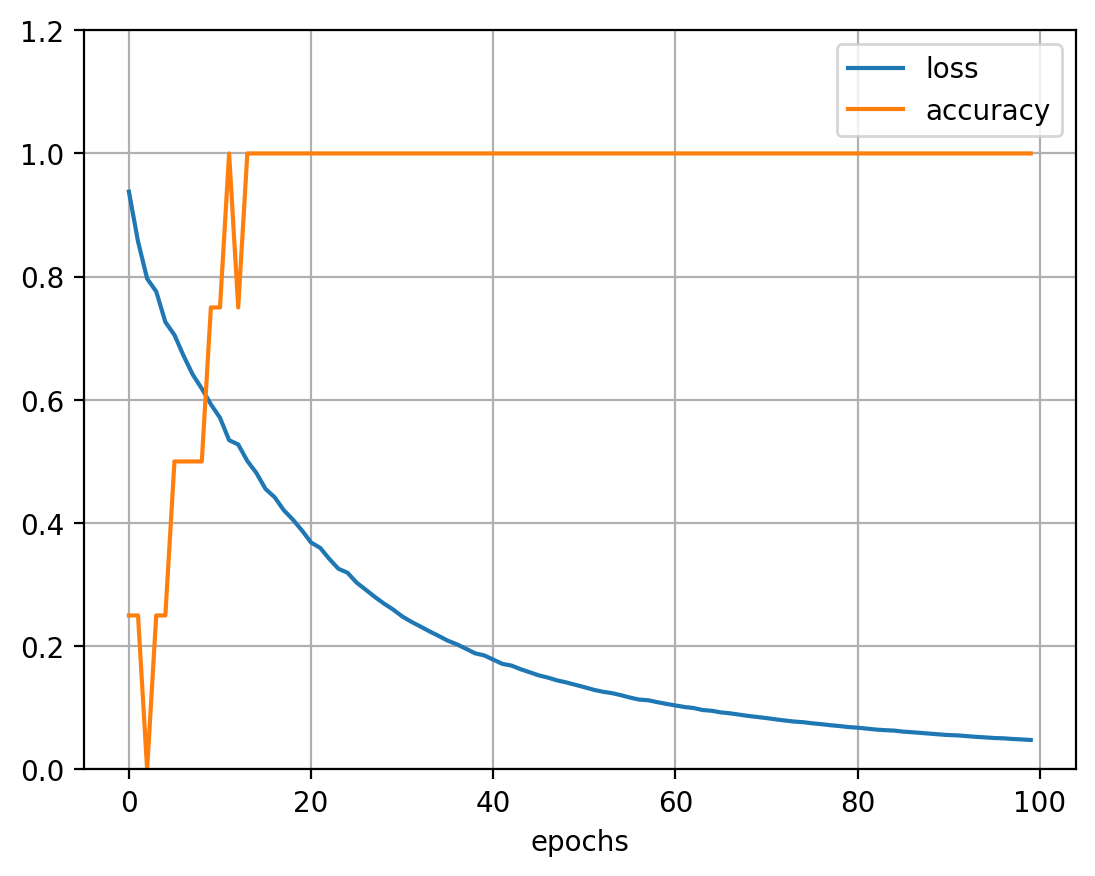


最適化の最終結果：
　　損失 = 0.04783545
　　精度 = 1.00000000

モデルの性能（最適化の前→後）：
　　損失 = 0.80841144 → 0.04648520
　　精度 = 0.50000000 → 1.00000000

テスト結果の要約：
　　XOR: 入力値 = [0, 0], 予測値 = [0.10142270] ⇨ [0], 正解値 = 0, ✓ PASS
　　XOR: 入力値 = [0, 1], 予測値 = [0.97262479] ⇨ [1], 正解値 = 1, ✓ PASS
　　XOR: 入力値 = [1, 0], 予測値 = [0.97031998] ⇨ [1], 正解値 = 1, ✓ PASS
　　XOR: 入力値 = [1, 1], 予測値 = [0.02089067] ⇨ [0], 正解値 = 0, ✓ PASS


In [ ]:
x_train = np.array([                              # 特徴量データ
    [0, 0], [0, 1], [1, 0], [1, 1]
])

target = {                                        # 正解値データ
    'AND':  np.array([ 0, 0, 0, 1 ]),
    'OR':   np.array([ 0, 1, 1, 1 ]),
    'XOR':  np.array([ 0, 1, 1, 0 ])
}

logic = 'XOR'                                     # 再現する論理回路を設定
t_train = target[logic]                           # 正解値データを確定

model = Model(2, eta=0.1)                         # 入力層（入力数 = 2）
model.add(20, relu, relu_der, fini=he_normal)     # 中間層（ニューロン数 = 20）
model.add(1, sigmoid, fini=xavier_normal)         # 出力層（ニューロン数 = 1）
model.measurer(bin_xentropy, bin_accuracy)        # 測定系の関数（損失関数、評価関数）を設定

bef = model.evaluate(x_train, t_train)            # 最適化「前」の性能を取得
fit = model.fit(x_train, t_train, epochs=100, batch_size=1, verbose=0) # 最適化
aft = model.evaluate(x_train, t_train)            # 最適化「後」の性能を取得
y_train = model.predict(x_train)                  # 特徴量データ4件に対する予測値を取得

show_progress(fit)                                # 最適化の経過を表示
show_perform(bef, aft)                            # モデルの性能を表示
show_summary_logic(logic, x_train, y_train, t_train) # テスト結果の要約を表示


## 【演習２】二値分類―タイタニック号の生存者を予測する

### Fiber

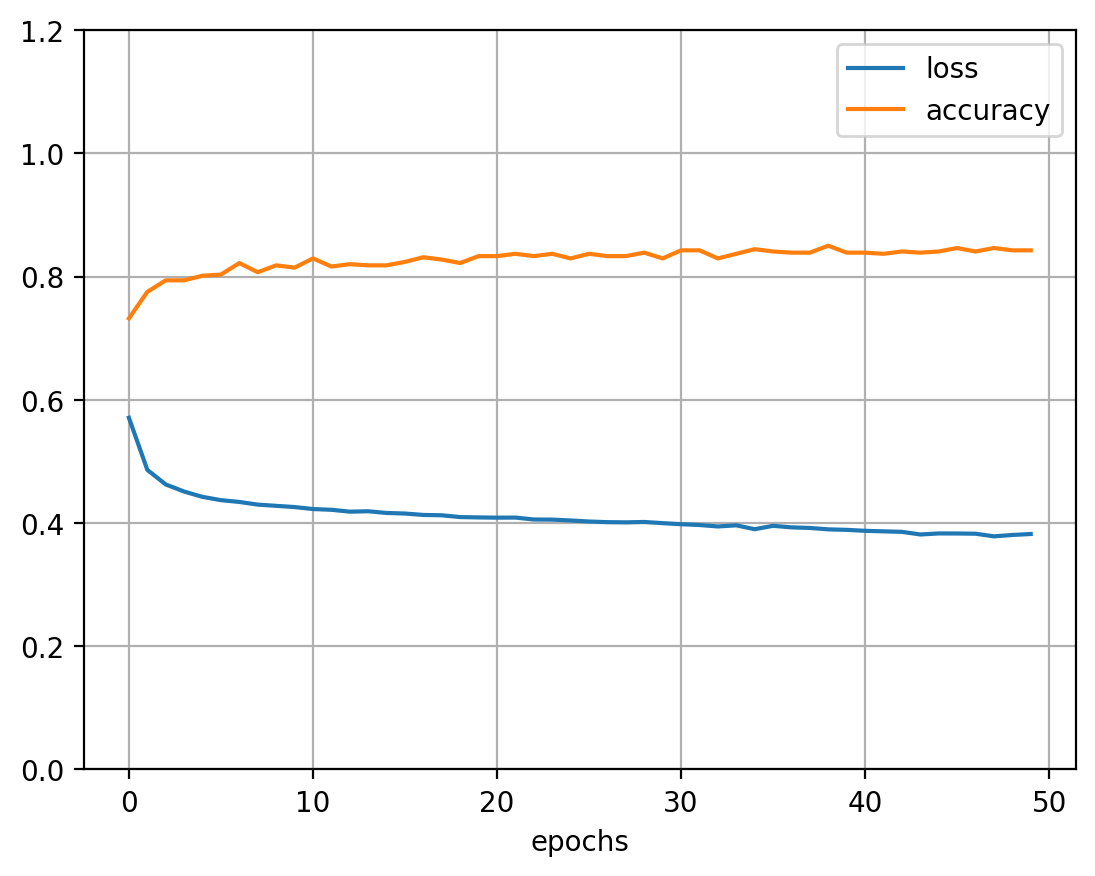


最適化の最終結果：
　　損失 = 0.38221330
　　精度 = 0.84269663

モデルの性能（最適化の前→後）：
　　損失 = 0.76464962 → 0.43716377
　　精度 = 0.46067416 → 0.81460674

テスト結果の要約：
　　予測値 = [0.14136849] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.99174656] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.07969326] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.18550488] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.25273050] ⇨ [0], 正解値 = [1], ✗ FAIL
　　予測値 = [0.11528957] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.10198251] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.26098010] ⇨ [0], 正解値 = [1], ✗ FAIL
　　予測値 = [0.22190111] ⇨ [0], 正解値 = [1], ✗ FAIL
　　予測値 = [0.99057773] ⇨ [1], 正解値 = [1], ✓ PASS

実際に投入された特徴量データ（未処理）（10件）：


,pclass,sex,age,sibsp,parch,fare,embarked,正解値（生存）
0,1,male,71.0,0,0,49.5042,C,0
1,1,female,40.0,0,0,153.4625,S,1
2,3,male,35.0,0,0,7.05,S,0
3,3,male,22.0,0,0,7.8958,S,0
4,1,male,36.0,0,0,26.3875,S,1
5,2,male,30.0,1,0,24.0,C,0
6,3,male,55.5,0,0,8.05,S,0
7,1,male,35.0,0,0,26.2875,S,1
8,3,male,19.0,0,0,8.05,S,1
9,1,female,49.0,1,0,76.7292,C,1



実際に投入された特徴量データ（処理済）（10件）：


,pclass,sex,age,sibsp,parch,fare,embarked
0,-1.482983,0.756138,2.855666,-0.552714,-0.506787,0.282354,-2.049487
1,-1.482983,-1.322511,0.715189,-0.552714,-0.506787,2.247485,0.519588
2,0.908600,0.756138,0.369951,-0.552714,-0.506787,-0.520161,0.519588
3,0.908600,0.756138,-0.527669,-0.552714,-0.506787,-0.504172,0.519588
4,-1.482983,0.756138,0.438999,-0.552714,-0.506787,-0.154622,0.519588
5,-0.287191,0.756138,0.024713,0.522511,-0.506787,-0.199753,-2.049487
6,0.908600,0.756138,1.785428,-0.552714,-0.506787,-0.501257,0.519588
7,-1.482983,0.756138,0.369951,-0.552714,-0.506787,-0.156513,0.519588
8,0.908600,0.756138,-0.734812,-0.552714,-0.506787,-0.501257,0.519588
9,-1.482983,-1.322511,1.336618,0.522511,-0.506787,0.796990,-2.049487


In [ ]:
x_colm = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
t_colm = ['survived']                             # 正解値データ
c_colm = ['sex', 'embarked']
ds = preproc_seaborn(titanic, x_colm, t_colm, c_colm, 0.75) # 標準化を実行
lim = 10                                          # 予測で使うテストセットを10件に制限

model = Model(len(x_colm), eta=0.01)              # 入力層（入力数 = x_colmの要素数）
model.add(10, relu, relu_der, fini=he_normal)     # 中間層（ニューロン数 = 10）
model.add(1, sigmoid, fini=xavier_normal)         # 出力層（ニューロン数 = 1）
model.measurer(bin_xentropy, bin_accuracy)        # 測定系の関数（損失関数、評価関数）を設定

bef = model.evaluate(ds.x_test, ds.t_test)        # 最適化「前」の性能を取得
fit = model.fit(ds.x_train, ds.t_train, epochs=50, batch_size=1, verbose=0) # 最適化
aft = model.evaluate(ds.x_test, ds.t_test)        # 最適化「後」の性能を取得
y_test = model.predict(ds.x_test[:lim])           # テストセット10件に対する予測値を取得

show_progress(fit)                                # 最適化の経過を表示
show_perform(bef, aft)                            # モデルの性能を表示
show_summary_bin(y_test, ds.t_test)               # テスト結果の要約を表示

raw = pd.DataFrame(ds.x_test_org[:lim], columns=x_colm)
raw['正解値（生存）'] = ds.t_test_org[:lim]
std = pd.DataFrame(ds.x_test[:lim], columns=x_colm)
print('\n実際に投入された特徴量データ（未処理）（10件）：')
display(raw)
print('\n実際に投入された特徴量データ（処理済）（10件）：')
display(std)


### Keras

1/1 [==============================] - 0s 71ms/step


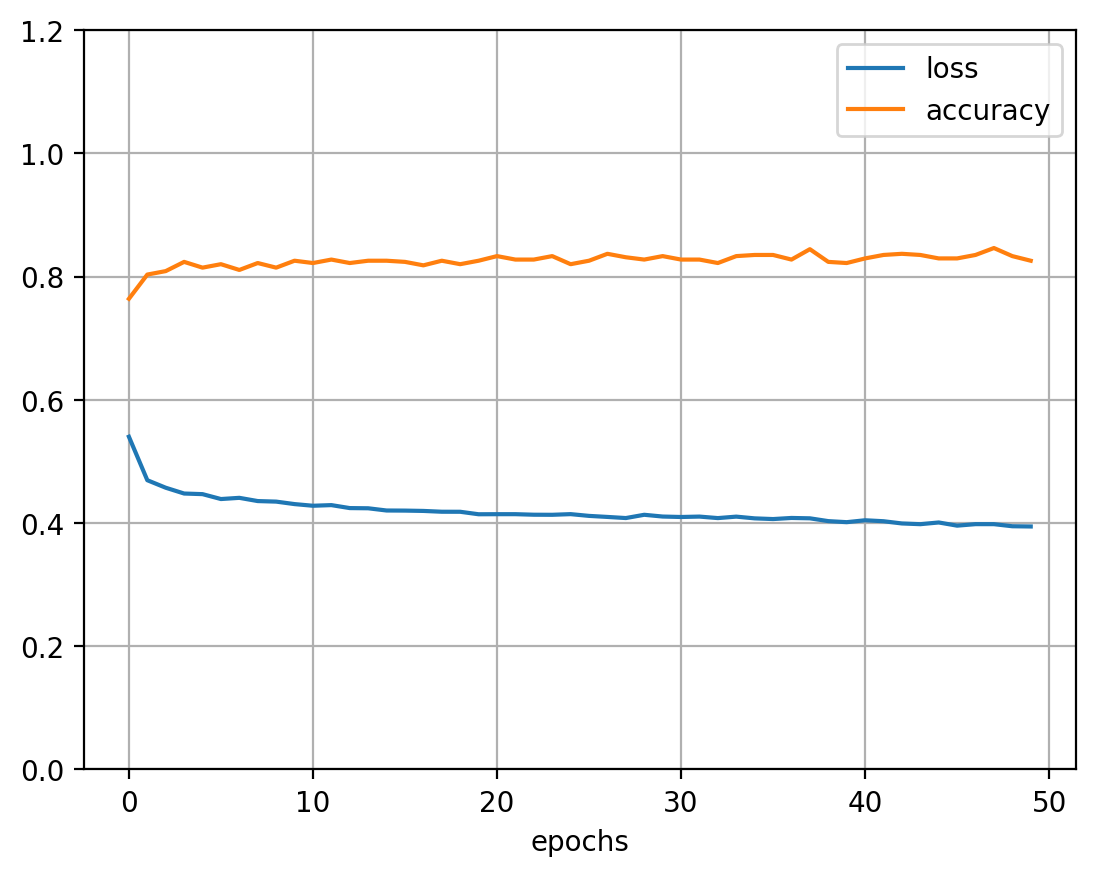


最適化の最終結果：
　　損失 = 0.39441204
　　精度 = 0.82584268

モデルの性能（最適化の前→後）：
　　損失 = 0.70026362 → 0.43589517
　　精度 = 0.43258426 → 0.83146065

テスト結果の要約：
　　予測値 = [0.09924703] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.96606165] ⇨ [1], 正解値 = [1], ✓ PASS
　　予測値 = [0.06630656] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.13144103] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.20672366] ⇨ [0], 正解値 = [1], ✗ FAIL
　　予測値 = [0.10055969] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.05990795] ⇨ [0], 正解値 = [0], ✓ PASS
　　予測値 = [0.21349367] ⇨ [0], 正解値 = [1], ✗ FAIL
　　予測値 = [0.15570372] ⇨ [0], 正解値 = [1], ✗ FAIL
　　予測値 = [0.99530268] ⇨ [1], 正解値 = [1], ✓ PASS


In [ ]:
bef = Object()
fit = Object()
aft = Object()

model = keras.Sequential([                        # 入力層（入力数 = 7）
    keras.layers.Dense(                           # 中間層（ニューロン数 = 10）
        10, 'relu', kernel_initializer='he_normal', input_shape=(7,)),
    keras.layers.Dense(                           # 出力層（ニューロン数 = 1）
        1, 'sigmoid', kernel_initializer='lecun_normal')
])
sgd = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

(bef.loss, bef.accu) = model.evaluate(ds.x_test, ds.t_test) # 最適化「前」の性能を取得
history = model.fit(ds.x_train, ds.t_train, epochs=50, batch_size=1, verbose=0)
(aft.loss, aft.accu) = model.evaluate(ds.x_test, ds.t_test) # 最適化「後」の性能を取得
y_test = model.predict(ds.x_test[:lim])                     # テストセット10件に対する予測値を取得

fit.loss = history.history['loss']
fit.accu = history.history['accuracy']

show_progress(fit)                                # 最適化の経過を表示
show_perform(bef, aft)                            # モデルの性能を表示
show_summary_bin(y_test, ds.t_test)               # テスト結果の要約を表示


## 【演習３】多値分類―アヤメの特徴から品種を推測する

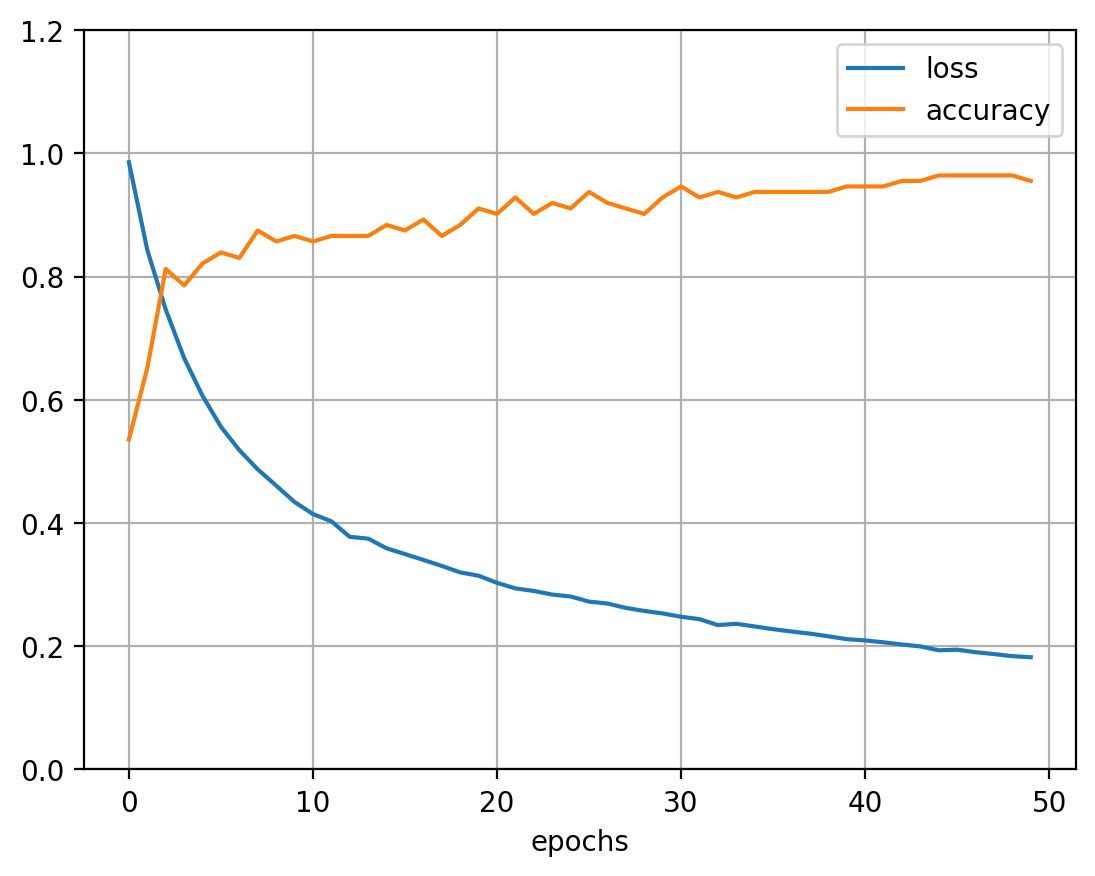


最適化の最終結果：
　　損失 = 0.18211764
　　精度 = 0.95535714

モデルの性能（最適化の前→後）：
　　損失 = 1.22423726 → 0.18760895
　　精度 = 0.28947368 → 0.94736842

テスト結果の要約：
　　予測値 = [0.02173567, 0.85159623, 0.12666810] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.96980092, 0.03019315, 0.00000593] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.03710955, 0.93403731, 0.02885313] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.97597504, 0.02402201, 0.00000295] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.02046309, 0.74099326, 0.23854365] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.00035167, 0.29045265, 0.70919568] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.98863761, 0.01136060, 0.00000179] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.02800231, 0.80774476, 0.16425293] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.00046879, 0.31288510, 0.68664611] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.00065115, 0.18946053, 0.80988831] ⇨ 2, 正解値 = 2, ✓ PASS

実際に投入された特徴量データ（未処理）（10件）：


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),正解値（品種）
0,6.2,2.9,4.3,1.3,1
1,5.0,3.4,1.6,0.4,0
2,5.8,2.7,4.1,1.0,1
3,5.0,3.4,1.5,0.2,0
4,6.7,3.1,4.4,1.4,1
5,6.3,2.5,5.0,1.9,2
6,5.1,3.8,1.6,0.2,0
7,5.9,3.0,4.2,1.5,1
8,5.7,2.5,5.0,2.0,2
9,6.5,3.0,5.2,2.0,2



実際に投入された特徴量データ（処理済）（10件）：


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.432165,-0.362176,0.308059,0.132510
1,-1.021849,0.788808,-1.226552,-1.052180
2,-0.052506,-0.822570,0.194384,-0.262387
3,-1.021849,0.788808,-1.283389,-1.315444
4,1.038005,0.098217,0.364896,0.264142
5,0.553333,-1.282963,0.705921,0.922303
6,-0.900681,1.709595,-1.226552,-1.315444
7,0.068662,-0.131979,0.251221,0.395774
8,-0.173674,-1.282963,0.705921,1.053935
9,0.795669,-0.131979,0.819596,1.053935


In [ ]:
ds = preproc_scikit(iris, 0.75)                   # 標準化を実行
lim = 10                                          # 予測で使うテストセットを10件に制限

model = Model(4, eta=0.01)                        # 入力層（入力数 = 4）       4つの特徴
model.add(32, sigmoid, sigmoid_der)               # 中間層（ニューロン数 = 32）
model.add(3, softmax)                             # 出力層（ニューロン数 = 3） 3品種に分類
model.measurer(cat_xentropy, cat_accuracy)        # 測定系の関数（損失関数、評価関数）を設定

bef = model.evaluate(ds.x_test, ds.t_test)        # 最適化「前」の性能を取得
fit = model.fit(ds.x_train, ds.t_train, epochs=50, batch_size=1) # 最適化
aft = model.evaluate(ds.x_test, ds.t_test)        # 最適化「後」の性能を取得
y_test = model.predict(ds.x_test[:lim])           # テストセット10件に対する予測値を取得

show_progress(fit)                                # 最適化の経過を表示
show_perform(bef, aft)                            # モデルの性能を表示
show_summary_cat(y_test, ds.t_test[:lim], 8)      # テスト結果の要約を表示

raw = pd.DataFrame(ds.x_test_org[:lim], columns=iris.feature_names)
raw['正解値（品種）'] = ds.t_test_org[:lim]
std = pd.DataFrame(ds.x_test[:lim], columns=iris.feature_names)
print('\n実際に投入された特徴量データ（未処理）（10件）：')
display(raw)
print('\n実際に投入された特徴量データ（処理済）（10件）：')
display(std)


## 【演習４】多値分類―手書きの数字を認識する

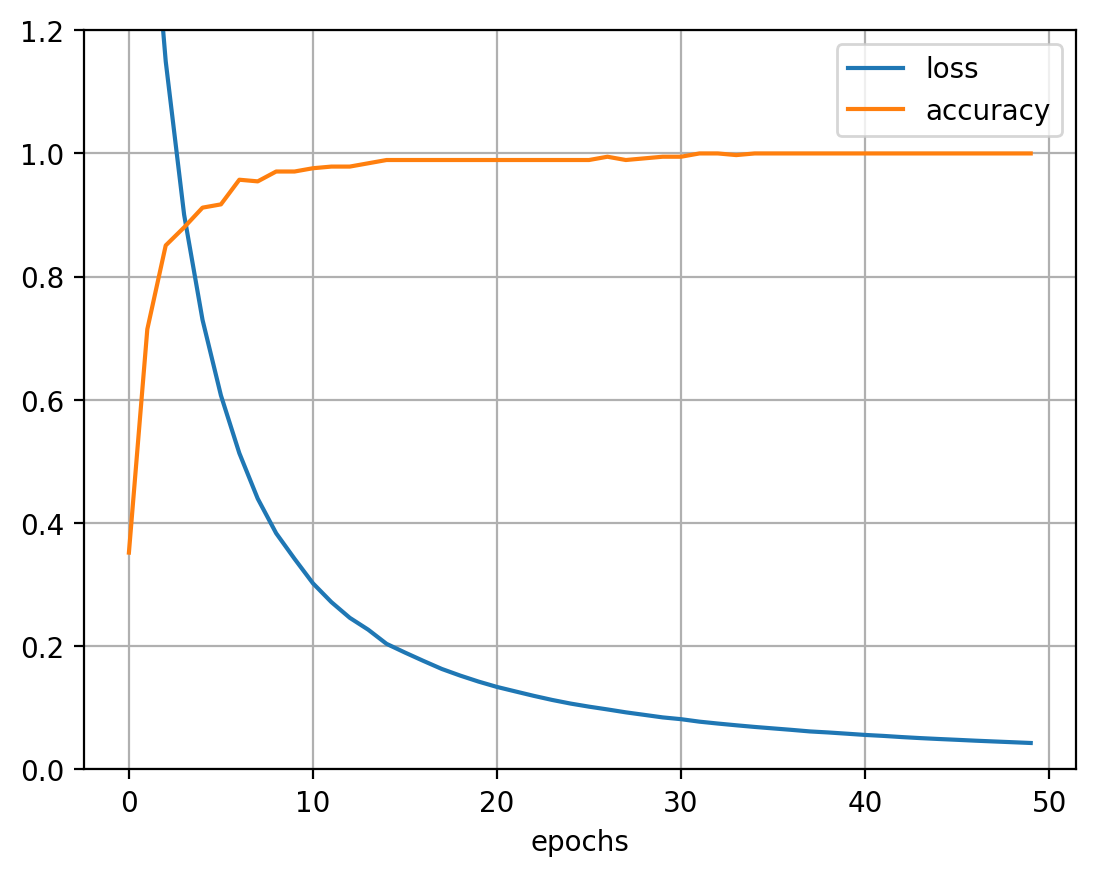


最適化の最終結果：
　　損失 = 0.04295157
　　精度 = 1.00000000

モデルの性能（最適化の前→後）：
　　損失 = 2.34518109 → 0.09274927
　　精度 = 0.07200000 → 0.99200000

テスト結果の要約：
　　予測値 = [0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.99, 0.00] ⇨ 8, 正解値 = 8, ✓ PASS
　　予測値 = [0.00, 0.88, 0.03, 0.00, 0.01, 0.00, 0.03, 0.00, 0.05, 0.00] ⇨ 1, 正解値 = 1, ✓ PASS
　　予測値 = [0.00, 0.00, 0.00, 0.03, 0.00, 0.96, 0.00, 0.00, 0.00, 0.00] ⇨ 5, 正解値 = 5, ✓ PASS
　　予測値 = [0.00, 0.00, 0.00, 0.00, 0.99, 0.00, 0.00, 0.00, 0.00, 0.00] ⇨ 4, 正解値 = 4, ✓ PASS
　　予測値 = [0.00, 0.00, 0.00, 0.02, 0.00, 0.00, 0.00, 0.00, 0.00, 0.97] ⇨ 9, 正解値 = 9, ✓ PASS
　　予測値 = [0.98, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.00, 0.03, 0.94, 0.00, 0.01, 0.00, 0.01, 0.02, 0.00, 0.00] ⇨ 2, 正解値 = 2, ✓ PASS
　　予測値 = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00] ⇨ 7, 正解値 = 7, ✓ PASS
　　予測値 = [0.94, 0.00, 0.00, 0.00, 0.00, 0.04, 0.00, 0.00, 0.00, 0.01] ⇨ 0, 正解値 = 0, ✓ PASS
　　予測値 = [0.00, 0.00, 0.00, 0.00, 0.00, 0.99, 0.00, 0

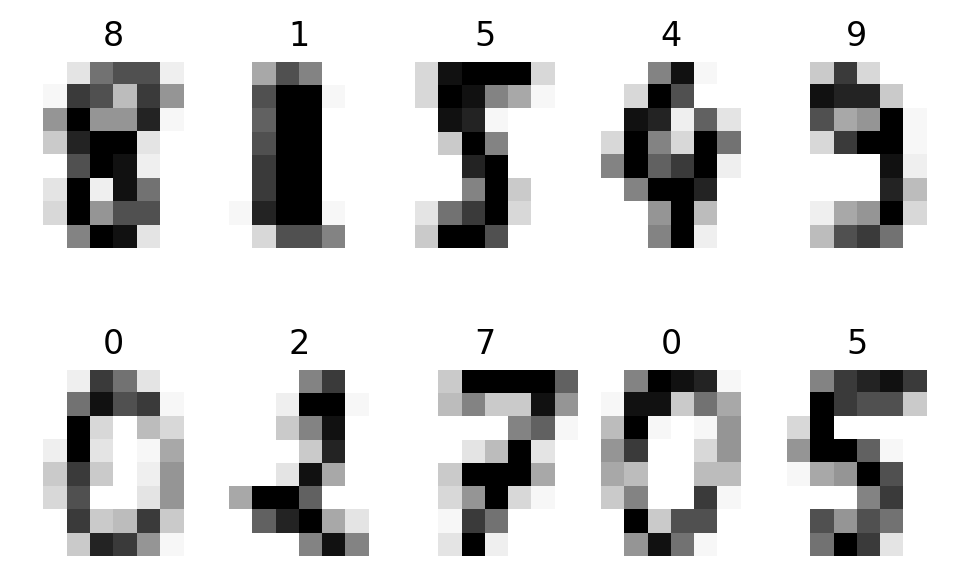


実際に投入された特徴量データ（未処理）（1件／8x8画素）：


,0,1,2,3,4,5,6,7
0,0,0,3,10,12,12,2,0
1,0,1,13,12,6,13,8,0
2,0,8,16,8,8,14,1,0
3,0,5,14,16,16,3,0,0
4,0,0,12,16,15,2,0,0
5,0,3,16,2,15,10,0,0
6,0,4,16,8,12,12,0,0
7,0,0,9,16,15,3,0,0



実際に投入された特徴量データ（処理済）（1件／8x8画素）：


,0,1,2,3,4,5,6,7
0,0.0000,-0.3349,-0.3976,-0.2285,0.1021,1.1385,0.1857,-0.1542
1,-0.0448,-0.2638,0.5141,-0.0594,-1.2873,0.7615,1.5691,-0.1628
2,0.0000,1.7322,1.0669,0.0660,0.0223,0.9599,-0.2412,-0.1123
3,-0.0448,0.9260,0.7348,1.1882,0.9253,-0.8166,-0.6135,0.0000
4,0.0000,-0.7010,0.6465,1.1114,0.7515,-1.2114,-0.7914,0.0000
5,0.0000,0.6526,1.3076,-0.8495,1.0528,0.2363,-0.8072,-0.0634
6,0.0000,2.1954,1.4356,-0.4181,0.2779,0.5036,-0.7177,-0.1372
7,0.0000,-0.3269,0.7137,0.9656,0.7234,-0.6459,-0.5106,-0.1221


In [ ]:
digits.data   = digits.data[:500]
digits.target = digits.target[:500]
ds = preproc_scikit(digits, 0.75)                 # 標準化を実行
lim = 10                                          # 予測で使うテストセットを10件に制限

model = Model(64, eta=0.01)                       # 入力層（入力数 = 64）       8x8画素
model.add(30, sigmoid, sigmoid_der)               # 中間層（ニューロン数 = 30）
model.add(10, softmax)                            # 出力層（ニューロン数 = 10） 0-9を識別
model.measurer(cat_xentropy, cat_accuracy)        # 測定系の関数（損失関数、評価関数）を設定

bef = model.evaluate(ds.x_test, ds.t_test)        # 最適化「前」の性能を取得
fit = model.fit(ds.x_train, ds.t_train, epochs=50, batch_size=50) # 最適化
aft = model.evaluate(ds.x_test, ds.t_test)        # 最適化「後」の性能を取得
y_test = model.predict(ds.x_test[:lim])           # テストセット10件に対する予測値を取得

show_progress(fit)                                # 最適化の経過を表示
show_perform(bef, aft)                            # モデルの性能を表示
show_summary_cat(y_test, ds.t_test, 2)            # テスト結果の要約を表示

ds.x_test_org = ds.x_test_org[:lim].astype(int).reshape(lim, 8, 8)

print('\n実際に投入された特徴量データ（正解値と画像）（10件／8x8画素）：')
plt.figure(figsize=(6, 4))
plt.subplots_adjust(wspace=0, hspace=0)
for (i, (img, t)) in enumerate(zip(ds.x_test_org, ds.t_test)):
    plt.subplot(2, 5, i + 1)
    plt.axis('off')
    plt.title(np.argmax(t))
    plt.imshow(img, cmap='Greys')                 # 手書きの数字の階調情報を画像化
plt.show()

raw = pd.DataFrame(ds.x_test_org[0])
std = pd.DataFrame(np.round(ds.x_test[0].reshape(8, 8), 4))
print('\n実際に投入された特徴量データ（未処理）（1件／8x8画素）：')
display(raw)
print('\n実際に投入された特徴量データ（処理済）（1件／8x8画素）：')
display(std)
